In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras import layers
import pydot
from keras import Model

In [2]:
from keras.datasets import fashion_mnist

In [3]:
(train_images,train_labels),(test_images,test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [4]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images = train_images / 255.0
test_images = test_images / 255.0

In [5]:
print(train_labels)

[9 0 0 ... 3 0 5]


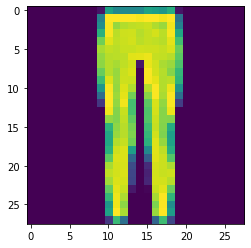

In [6]:
plt.imshow(train_images[16])
plt.imshow(train_images[38])


In [7]:
def create_pairs_on_set(images,labels):
  digits_indices = [np.where(labels == i)[0] for i in range(10)]
  pairs,y = create_pairs(images,digits_indices)
  y = y.astype('float32')
  return pairs,y

In [8]:
import random

In [9]:
def create_pairs(x,digits_indices):

  pairs = []
  labels = []

  # finding the label which has minimum images in the dataset
  n = min([len(digits_indices[i]) for i in range(10)]) - 1

  for d in range(10):
    for i in range(n):
      #similar images
      x1, x2 = digits_indices[d][i], digits_indices[d][i+1]
  
      pairs += [[x[x1], x[x2]]]
      inc = random.randrange(1,10)
      dn = (d + inc) % 10
      # disimilar images
      x1, x2 = digits_indices[d][i], digits_indices[dn][i]
      pairs += [[x[x1], x[x2]]]
      labels += [1,0] #first image pair is similar whereas the other is disimilar
  return np.array(pairs), np.array(labels)

In [10]:
train_pairs, train_y = create_pairs_on_set(train_images,train_labels)

In [11]:
test_pairs, test_y = create_pairs_on_set(test_images,test_labels)

In [12]:
digits_indices = [np.where(test_labels == i) for i in range(10)]

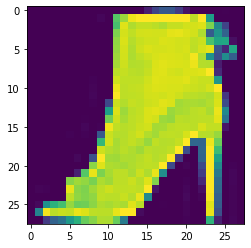

In [13]:
plt.imshow(test_images[9964])

In [14]:
# Creating a base network
def initialize_base_network():
  #input layer
  input = layers.Input(shape=(28,28),name='base_input')

  #model layers
  flatten_layer = layers.Flatten(name='flatten_layer')(input)
  first_dense = layers.Dense(128,activation='relu',name='first_dense')(flatten_layer)
  first_dropout = layers.Dropout(0.3,name='first_dropout')(first_dense)
  second_dense = layers.Dense(128,activation='relu',name='second_dense')(first_dropout)
  second_dropout = layers.Dropout(0.3,name='second_dropout')(second_dense)

  #output 
  output = layers.Dense(128,activation='relu',name='output')(second_dropout)
  return tf.keras.Model(inputs=input,outputs=output)

In [15]:
base_model = initialize_base_network()

In [16]:
from tensorflow.python.keras.utils.vis_utils import plot_model

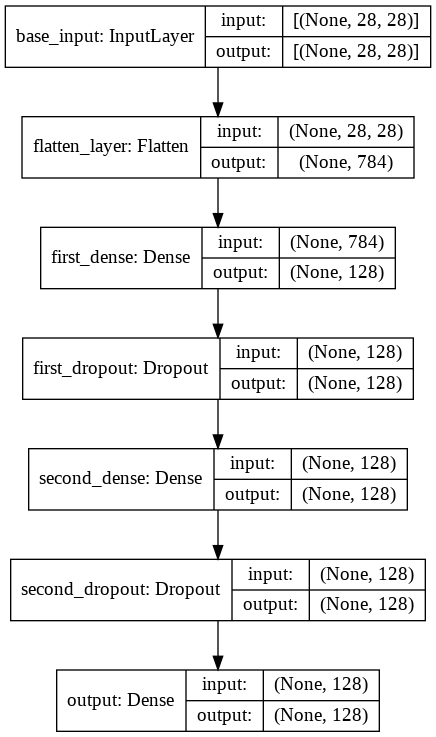

In [17]:
plot_model(base_model,show_shapes=True,show_layer_names=True)

In [18]:
from keras import backend as k

In [19]:
def euclidean_distance(vects):
  x,y = vects 
  sum_square = k.sum(k.square(x-y), axis=1, keepdims=True)
  return k.sqrt(k.maximum(sum_square,k.epsilon()))

In [20]:
def euc_dist_ouput(shapes):
  shape1,shape2 = shapes
  return (shape1[0],1)

In [21]:
# Creating the siamese network
input_a = layers.Input(shape=(28,28,),name='left_input')
vect_output_a = base_model(input_a)

input_b = layers.Input(shape=(28,28,),name='right_input')
vect_output_b = base_model(input_b)

output = layers.Lambda(euclidean_distance,name='output_layer',output_shape=euc_dist_ouput)([vect_output_a,vect_output_b])
final_model = tf.keras.Model(inputs=[input_a,input_b],outputs=output)



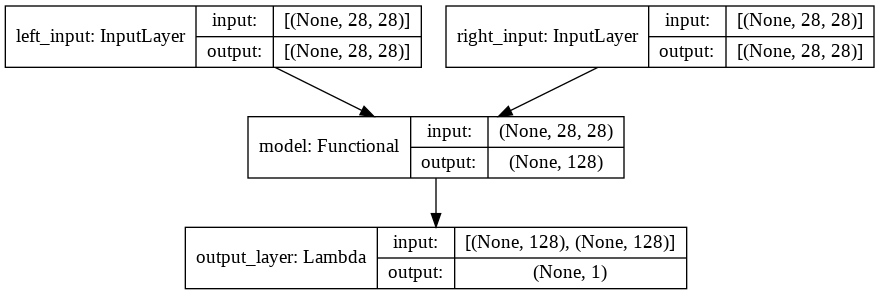

In [22]:
plot_model(final_model,show_shapes=True,show_layer_names=True)

In [26]:
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true,y_pred):

    square_pred = k.square(y_pred)
    margin_square = k.square(k.maximum(margin - y_pred,0))
    return k.mean(y_true * square_pred + (1 - y_true) * margin_square)
  return contrastive_loss

In [27]:
from tensorflow.keras.optimizers import RMSprop

In [28]:
rms = RMSprop()
final_model.compile(loss=contrastive_loss_with_margin(margin=1),optimizer=rms)
history = final_model.fit([train_pairs[:,0],train_pairs[:,1]],train_y,epochs=20,
                    validation_data=([test_pairs[:,0],test_pairs[:,1]],test_y))

Epoch 1/20
3750/3750 [==============================] - 20s 5ms/step - loss: 0.1360 - val_loss: 0.1065
Epoch 2/20
3750/3750 [==============================] - 20s 5ms/step - loss: 0.1045 - val_loss: 0.0964
Epoch 3/20
3750/3750 [==============================] - 20s 5ms/step - loss: 0.0950 - val_loss: 0.0917
Epoch 4/20
3750/3750 [==============================] - 20s 5ms/step - loss: 0.0901 - val_loss: 0.0870
Epoch 5/20
3750/3750 [==============================] - 22s 6ms/step - loss: 0.0885 - val_loss: 0.0882
Epoch 6/20
3750/3750 [==============================] - 20s 5ms/step - loss: 0.0871 - val_loss: 0.0857
Epoch 7/20
3750/3750 [==============================] - 21s 5ms/step - loss: 0.0865 - val_loss: 0.0888
Epoch 8/20
3750/3750 [==============================] - 20s 5ms/step - loss: 0.0856 - val_loss: 0.0860
Epoch 9/20
3750/3750 [==============================] - 20s 5ms/step - loss: 0.0858 - val_loss: 0.0843
Epoch 10/20
3750/3750 [==============================] - 20s 5ms/step - l

In [ ]:
train_pairs.shape

(0,)

In [29]:
# Model Evaluation

def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [31]:
loss = final_model.evaluate(x=[test_pairs[:,0],test_pairs[:,1]], y=test_y)

y_pred_train = final_model.predict([train_pairs[:,0], train_pairs[:,1]])
train_accuracy = compute_accuracy(train_y, y_pred_train)

y_pred_test = final_model.predict([test_pairs[:,0], test_pairs[:,1]])
test_accuracy = compute_accuracy(test_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 1s 2ms/step - loss: 0.0813
Loss = 0.08134092390537262, Train Accuracy = 0.9073845640940157 Test Accuracy = 0.8948448448448448


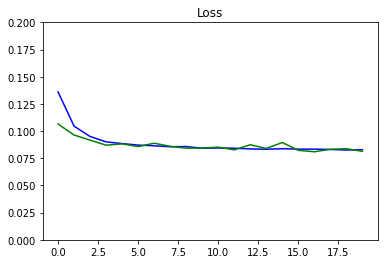

In [32]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [33]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)



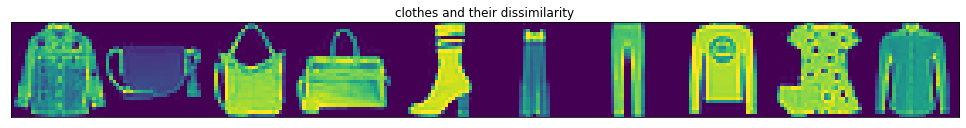

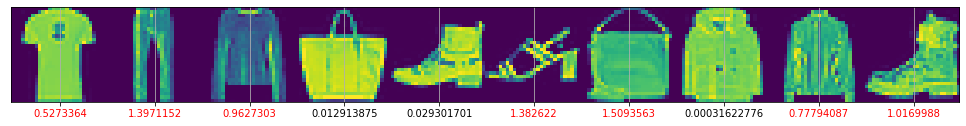

In [35]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(train_pairs[:, 0][indexes], train_pairs[:, 1][indexes], y_pred_train[indexes], train_y[indexes], "clothes and their dissimilarity", 10)